# HARK and SSJ example

By William Du (wdu9@jhu.edu) 


- This notebook demonstrates how HARK and the Sequence Space Jacobian toolkit can be combined to solve HANK models.
    - And is heavily drawn from this [SSJ notebook](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%201%20Fiscal%20Policy.ipynb) .

- HARK was designed to solve rich microeconomic models, including:
    - Lifecycle models
    - Discrete-continuous choice
    - Portfolio choice

</br>

- SSJ was created to solve HANK models with incredible speed and ease

- The SSJ method and toolkit (Auclert et al) is utterly fantastic and game-changing

- Big insight: Solving the microeconomic model (in steady state) can be *independent* of working out macroeconomic dynamics

- Connecting HARK to SSJ allows us to solve macro models with rich micro features


# Model


To begin, a basic HANK model is introduced. The model follows the [lecture slides](https://github.com/shade-econ/nber-workshop-2022/blob/main/Lectures/Lecture%204%20Fiscal%20Policy.pdf) from the SSJ authors' heterogeneous agent workshop.

## Basic model features

- Heterogenous agent households that consume/save into one asset

- Households face idiosyncratic income shocks

- Cobb-Douglas production function with labor and capital

- Sticky wages

- To pay its expenditures, government taxes labor income and rolls over its debt


# Bringing Model to Code

To implement the model, we first need to import some basic, commonly used numeric tools (e.g. numpy and scipy), as well as an AgentType subclass from HARK. Additionally, we import the SSJ toolkit to apply as an additional layer on top of the microeconomic model.

In [1]:
# Basic scientific tools
import time

import matplotlib.pyplot as plt
import numpy as np
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from scipy import optimize

# Sequence space Jacobian toolkit
from sequence_jacobian.classes import JacobianDict, SteadyStateDict

# HARK agents
from HARK.ConsumptionSaving.ConsNewKeynesianModel import NewKeynesianConsumerType

### Calibrate Steady State Values

Next, we calibrate the steady state values of some outcomes, and calculate a few values implied by them.

In [2]:
# Steady state calibration
r_ss = 0.03  # Interest rate
G_ss = 0.2  # Government spending
B_ss = 0.2  # Government debt (bonds)
Y_ss = 1.0  # Output

# Implied steady state values
T_ss = G_ss + r_ss * B_ss  # Lump sum taxes to keep debt constant
Z_ss = Y_ss - T_ss  # After tax labor income
F_ss = G_ss - T_ss  # Government budget deficit

### Microeconomic Agent Parameters

To make our microeconomic agents in HARK, we need a dictionary of parameters, defined below. There are additional parameters that fully specify a NewKeynesianConsumerType, but we can leave them at their default values by not specifying them.

In [3]:
HANK_dict = {
    "Rfree": 1.0 + r_ss,  # Interest factor on assets
    "tax_rate": [0.0],  # Assume that labor here is actually after tax income
    "labor": [Z_ss],  # Will be solving the micro model in steady state
    "UnempPrb": 0.0,  # Probability of unemployment while working
    "IncUnemp": 0.0,  # Unemployment benefits replacement rate
}

## Find Appropriate Discount Factor

Above, we exogenously calibrated the steady state level of government debt $B_{ss}$. These bonds should be *owned* by someone, so we need our agents to want to hold the same level of assets as there are government bonds. To do so, we specify a function that yields steady state asset holdings as a function of agents' discount factor $\beta$, and another function that simply differences it with our target level of assets. The appropriate discount factor can then be found by performing a bounded search for a root of the difference function.

In [4]:
# Define a function that computes steady state aggregate assets as a function of the discount factor
def calc_SS_assets_from_discfac(beta):
    HANK_dict["DiscFac"] = beta  # set the proposed discount factor
    TempAgent = NewKeynesianConsumerType(
        **HANK_dict,
        verbose=False,
    )  # make an AgentType instance
    A_ss = TempAgent.compute_steady_state()[0]  # compute steady state assets
    return A_ss


# Define a simple function that differences steady state assets from target assets
def calc_asset_gap(beta):
    return calc_SS_assets_from_discfac(beta) - A_target


# Find the discount factor that makes steady state assets equal (calibrated) steady state government bonds
A_target = B_ss
DiscFac_star = optimize.brentq(calc_asset_gap, 0.85, 0.99)

## Make Agents with Calibrated Discount Factor

Now that we know what the discount factor should be, we can make an AgentType instance that will be used for the general equilibrium analysis. To do so, we simply put $\beta^*$ into our parameter dictionary and make a new instance of NewKeynesianConsumerType using it. To verify that we did what we set out to do, we can check that the output goods market clears (output is accounted for by consumption and government spending) and that the asset market clears (retained assets are accounted for by government bonds). Both conditions should be very close to zero.

In [5]:
# Create a HARK agent
HANK_dict["DiscFac"] = DiscFac_star
Agent_GE = NewKeynesianConsumerType(**HANK_dict, verbose=False)
A_ss, C_ss = Agent_GE.compute_steady_state()

# Verify market clearing conditions
print("Goods clearing condition:", Y_ss - C_ss - G_ss)
print("Asset clearing condition:", A_ss - B_ss)

Goods clearing condition: -5.717648576819556e-15
Asset clearing condition: 9.786615962070755e-14


## Compute Jacobian Matrices

A deep insight that has recently made a large impact for our ability to handle heterogeneous agents models with rich microeconomic heterogeneity is that the macroeconomy can be well approximated by linearization, which makes it possible to calculate the dynamics of the model with response to perfect foresight ``MIT shocks'', as opposed to needing to develop more complicated functions. The key to this is to compute the response of the microeconomic model to small future disturbances-- the Jacobian matrix.

HARK has a tool for calculating the Jacobian matrices that characterize consumption and asset responses to an exogenous *transitory* change in the interest factor (Rfree) or labor income (labor) that will occur in the future. This is accomplished with the calc_jacobian method, passing as arguments the name of the parameter that will be changed and the maximum number of periods in the future that a (marginal) change could occur.

The outputs of this method are objects that represent the sensitivity of aggregate consumption and asset holdings (respectively) in each period to the *advance knowledge* of an exogenous change in each parameter.

In [6]:
start = time.time()

# Derivatives of consumption and assets wrt R
dCdR, dAdR = Agent_GE.calc_jacobian(
    "Rfree",
    300,
)  # Jacobians of consumption and assets w.r.t. interest factor changes up to 300 periods ahead

# Derivatives with respect to after-tax labor income
dCdZ, dAdZ = Agent_GE.calc_jacobian(
    "labor",
    300,
)  # Jacobians of consumption and assets w.r.t. labor supply changes up to 300 periods ahead

print(f"Time to compute Jacobians: {time.time() - start:.3f} seconds.")

Time to compute Jacobians: 4.083 seconds.


## Plot Jacobians

To inspect the Jacobian matrix for aggregate consumption, we can plot some of its rows/columns, representing the consumption response to a change in the interest factor or labor income $T$ periods in the future.

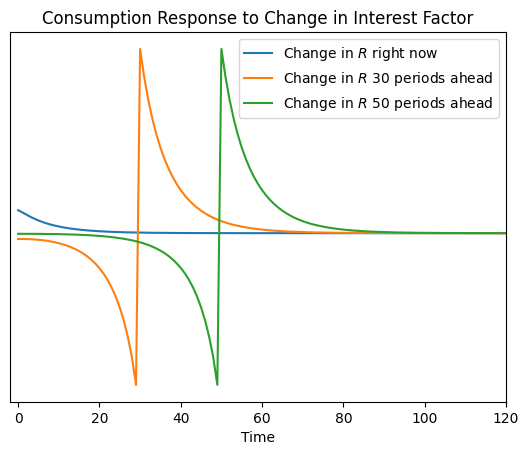

In [7]:
plt.plot(dCdR.T[0])
plt.plot(dCdR.T[30])
plt.plot(dCdR.T[50])
plt.legend(
    [
        r"Change in $R$ right now",
        r"Change in $R$ 30 periods ahead",
        r"Change in $R$ 50 periods ahead",
    ],
)
plt.xlim(-2, 120)
plt.title("Consumption Response to Change in Interest Factor")
plt.xlabel("Time")
plt.yticks([])
plt.show()

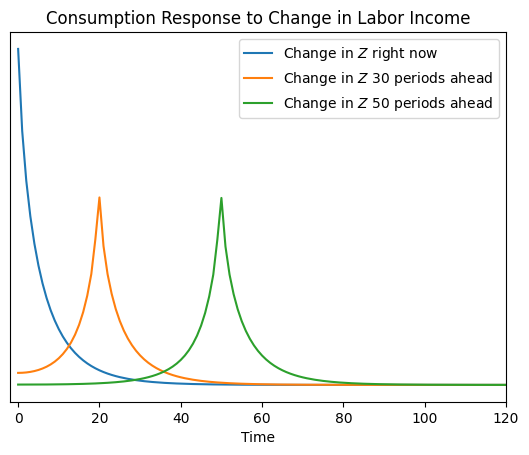

In [8]:
plt.plot(dCdZ.T[0])
plt.plot(dCdZ.T[20])
plt.plot(dCdZ.T[50])
plt.xlim(-2, 120)
plt.legend(
    [
        r"Change in $Z$ right now",
        r"Change in $Z$ 30 periods ahead",
        r"Change in $Z$ 50 periods ahead",
    ],
)
plt.xlim(-2, 120)
plt.title("Consumption Response to Change in Labor Income")
plt.xlabel("Time")
plt.yticks([])
plt.show()

# Government Budget Constraint and Market Clearing

We now need to specify the other blocks of this Fiscal HANK model. The details of the model found [here](https://github.com/shade-econ/nber-workshop-2022/blob/main/Lectures/Lecture%204%20Fiscal%20Policy.pdf) tell us that only the governemnt budget constraint and the market clearing conditions need to be specified explicitly to capture the dynamics of the HANK model.

The sequence space toolkit allows us to specify other blocks of the economy in a DYNARE-esque fashion as we simply need to write down the difference equations that define our model.

In [9]:
# Government Budget Constraint
@sj.simple
def fiscal(B, r, G, Y):
    T = (1 + r) * B(-1) + G - B  # total tax burden
    Z = Y - T  # after tax income
    deficit = G - T
    return T, Z, deficit


# Market Clearing Conditions
@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B  # asset market clearing
    goods_mkt = Y - C - G  # goods market clearing
    return asset_mkt, goods_mkt

In [10]:
# Store Jacobians in JacobianDict Object.
# This will capture behavior of heterogeneous hosueholds.
het_household_block = JacobianDict({"C": {"Z": dCdZ}, "A": {"Z": dAdZ}})

In [11]:
# SteadyStateDict:
# - Steady state values of each variable; we perturb around this steady state.
SteadyState_dict = SteadyStateDict(
    {
        "asset_mkt": 0.0,
        "goods_mkt": 0.0,
        "deficit": G_ss - T_ss,
        "B": B_ss,  # Gov. Debt
        "r": r_ss,  # Interest rate
        "G": G_ss,  # Gov. Spending
        "Y": Y_ss,  # Output
        "A": B_ss,  # Assets
        "C": C_ss,  # Consumption
        "Z": Y_ss - T_ss,  # Income (post-tax)
        "T": T_ss,  # Lump Sum Taxes
    },
)

In [12]:
# Create the model by combining three blocks:
# (1) microeconomic responses to macroeconomic news (Jacobians)
# (2) fiscal authority behavior
# (3) market clearing conditions
HANK = sj.create_model([het_household_block, fiscal, mkt_clearing], name="HA Model")

# Choose aggregate shock parameters for the simulation
T = 300  # <-- the length of the IRF
rho_G = 0.8  # peristence of shock
dG = 0.01 * rho_G ** np.arange(T)
shocks = {"G": dG}

# Obtain impulse responses
unknowns_td = ["Y"]  # unknowns to solve for to clear target condition below
targets_td = ["asset_mkt"]

# Solve for impulse responses to gov. spending shock (balanced budget)
irfs_G_lin = HANK.solve_impulse_linear(
    SteadyState_dict,
    unknowns_td,
    targets_td,
    shocks,
)

In [13]:
# Define a function that can plot impulse response functions
def show_irfs(
    irfs_list,
    variables,
    labels=[" "],
    ylabel=r"Percentage points (dev. from ss)",
    T_plot=50,
    figsize=(18, 6),
):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i == 0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

## Government Spending Shock (Balanced Budget)

The plot belows illustrate the impulse responses to a government spending shock that is completely funded by increases in taxes. 


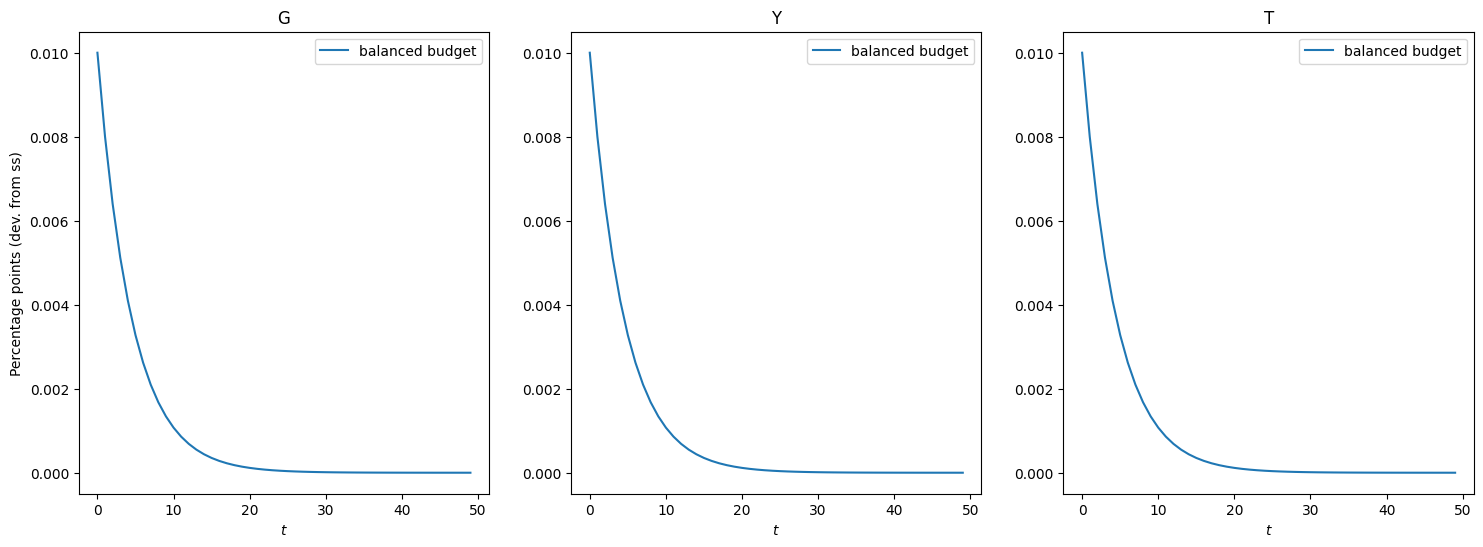

In [14]:
# Plot the Impulse Response Functi
show_irfs([irfs_G_lin], ["G", "Y", "T"], labels=["balanced budget"])

## Government spending shock (deficit financed)

Now let us produce the responses to a government spending shock when it is mostly deficit financed. 

To do so, we will shock government debt such that the cumulative sum of debt shock is equal to the cumulative sum of the increase in government spending.

In [15]:
# Define a 'fiscal rule' to this government spending shock
# by specifying a shock to debt that will finance the gov. spending shock
rho_B = 0.9  # how fast to move back toward fiscal target
dB = np.cumsum(dG) * rho_B ** np.arange(T)
shocks_B = {"G": dG, "B": dB}  # we will be shocking both government spending and debt

# Solve for impulse responses
irfs_B_lin = HANK.solve_impulse_linear(
    SteadyState_dict,
    unknowns_td,
    targets_td,
    shocks_B,
)

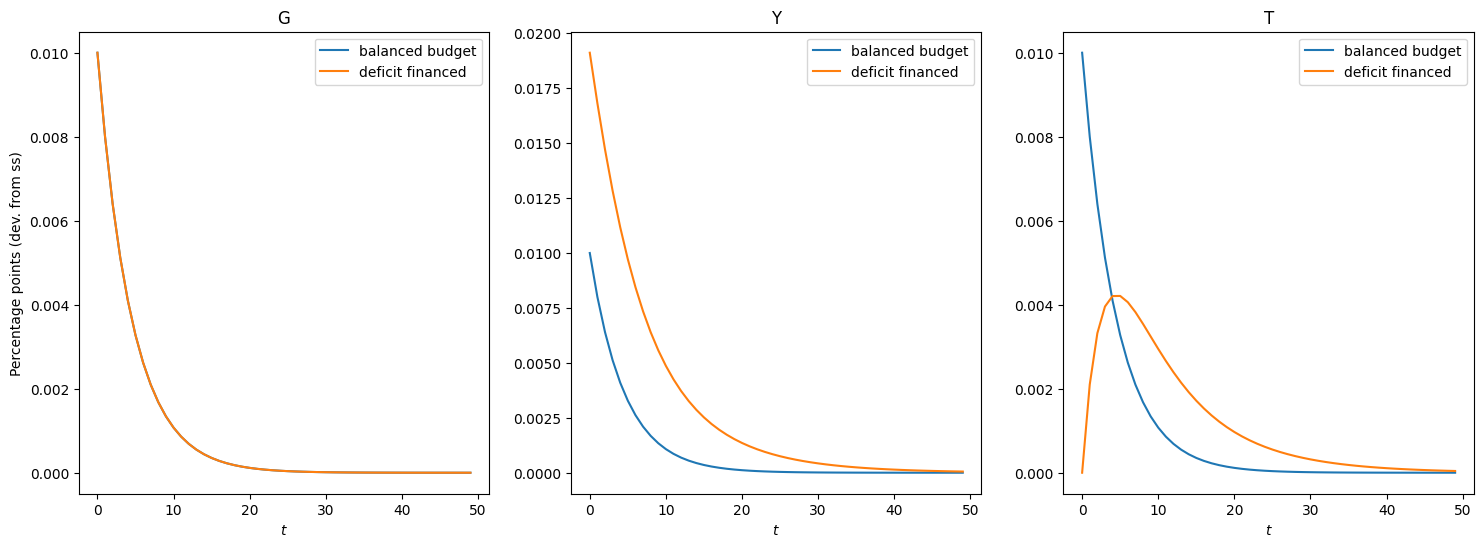

In [16]:
# Show government spending, output, and taxes
show_irfs(
    [irfs_G_lin, irfs_B_lin],
    ["G", "Y", "T"],
    labels=["balanced budget", "deficit financed"],
)

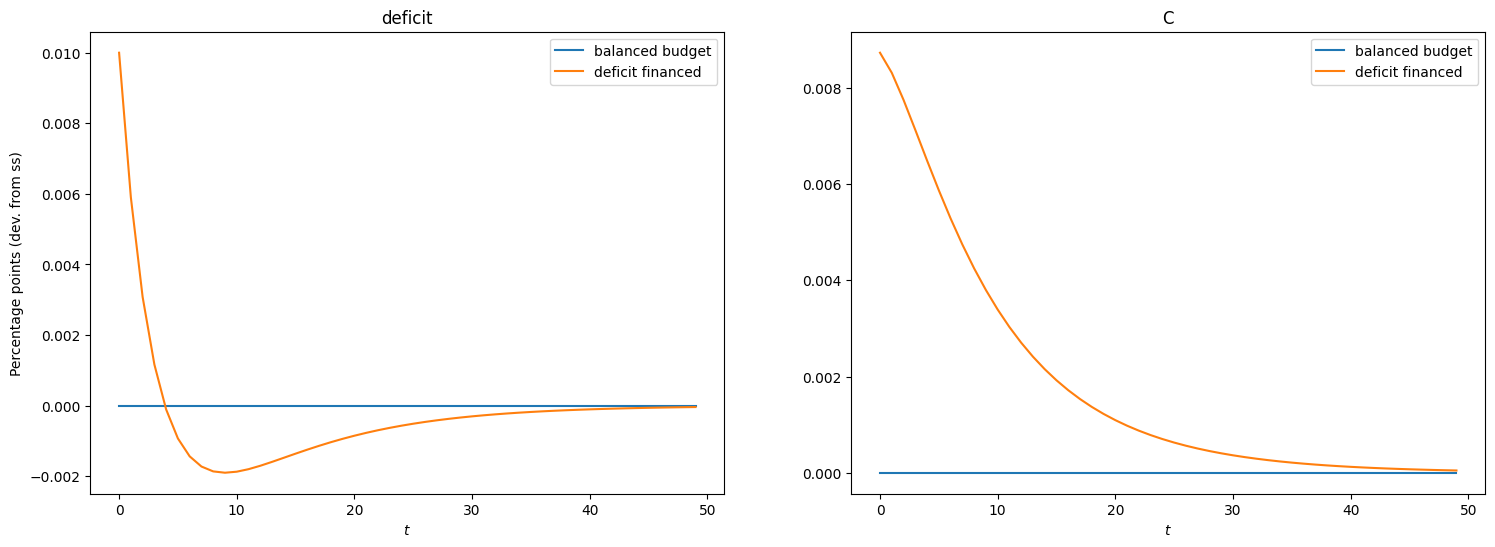

In [17]:
# Show the deficit and consumption
show_irfs(
    [irfs_G_lin, irfs_B_lin],
    ["deficit", "C"],
    labels=["balanced budget", "deficit financed"],
)

# Why does HANK matter?

Let us compare deficit financed government spending responses in HANK vs TANK vs RANK.

To do so, a representative agent and a two agent household block will be specified to produce a RANK and TANK model. 


## Specify a representative agent household

Since the representative agent household solution can be expressed analytically, below the difference equations (euler equation and budget constraint) that define the representative agent problem are specified. 

In [18]:
@sj.solved(
    unknowns={"C": 1, "A": 1},
    targets=["euler", "budget_constraint"],
)  # solver="broyden_custom")
def hh_ra(C, A, Z, eis, beta, r):
    euler = (beta * (1 + r(+1))) ** (-eis) * C(+1) - C  # RA euler equation
    budget_constraint = (1 + r) * A(-1) + Z - C - A  # RA budget constraint
    MPC = 0
    return euler, budget_constraint, MPC


# create RANK model where heterogeneous household block is replaced with representative agent block 'hh_ra'
RANK = sj.create_model([hh_ra, fiscal, mkt_clearing], name="Representative agent model")

## Specify a two agent economy (Campbell-Mankiw)

Similar to the rep. agent problem, the difference equations (euler equation and budget constraint) that define the two agent problem are specified. 

In [19]:
# Deep in SSJ weeds, we need this object:
@sj.solved(
    unknowns={"C_RA": 1, "A": 1},
    targets=["euler", "budget_constraint"],
)  # , solver="broyden_custom")
def hh_ta(C_RA, A, Z, eis, beta, r, lam):
    # consumption of infinitely lived household
    euler = (beta * (1 + r(+1))) ** (-eis) * C_RA(+1) - C_RA
    # hand to mouth agent consumes income Z
    C_H2M = Z
    # aggregate C is weighted sum of C of two types
    C = (1 - lam) * C_RA + lam * C_H2M  # lam is frac of hand to mouth households
    # aggregate budget constraint
    budget_constraint = (1 + r) * A(-1) + Z - C - A
    MPC = 0
    return euler, budget_constraint, C_H2M, C, MPC


# create TANK model where heterogeneous household is replaced with 'hh_ta'
TANK = sj.create_model([hh_ta, fiscal, mkt_clearing], name="Two agent model")

## Calibrate and find steady states of TANK and RANK models.

Now that we have defined the representative agent and two agent models, we need to solve for a steady state in each model for which we will perturb around later to solve for dynamics.

In [20]:
# base dictionary for calibrating representative agent and two agent household.
calibration = {
    "eis": 0.5,  # EIS
    "G": G_ss,  # Government spending
    "B": B_ss,  # Government debt
    "Y": Y_ss,  # Output
    "r": r_ss,
}  # Number of productivity grid points

In [21]:
# Rep Agent calibration
calibration_ra = calibration.copy()
calibration_ra["beta"] = 1 / (1 + calibration_ra["r"])  # for steady state consumption
calibration_ra["B"] = calibration["B"]

unknowns_ra_ss = {
    "C": 1.0,
    "A": 0.8,
}  # solve for two unknowns to clear the targets below
targets_ra_ss = {"budget_constraint": 0.0, "asset_mkt": 0.0}

# solve for steady state for RANK model
ss_RANK = RANK.solve_steady_state(
    calibration_ra,
    unknowns_ra_ss,
    targets_ra_ss,
    dissolve=["hh_ra"],
)  # solve steady state for RANK model

In [22]:
# Two Agent calibration
calibration_ta = calibration_ra.copy()  # dictionary for two agent block
calibration_ta["lam"] = 0.25  # proportion of hand to mouth
unknowns_ta_ss = {
    "C_RA": 1.0,
    "A": 0.8,
}  # solve for two unknowns to clear the targets below

# solve for steady state for TANK model
ss_TANK = TANK.solve_steady_state(
    calibration_ta,
    unknowns_ta_ss,
    targets_ra_ss,
    dissolve=["hh_ta"],
)  # solve steady state for TANK model

## Impulse responses to deficit financed G shocks: HANK vs TANK vs RANK

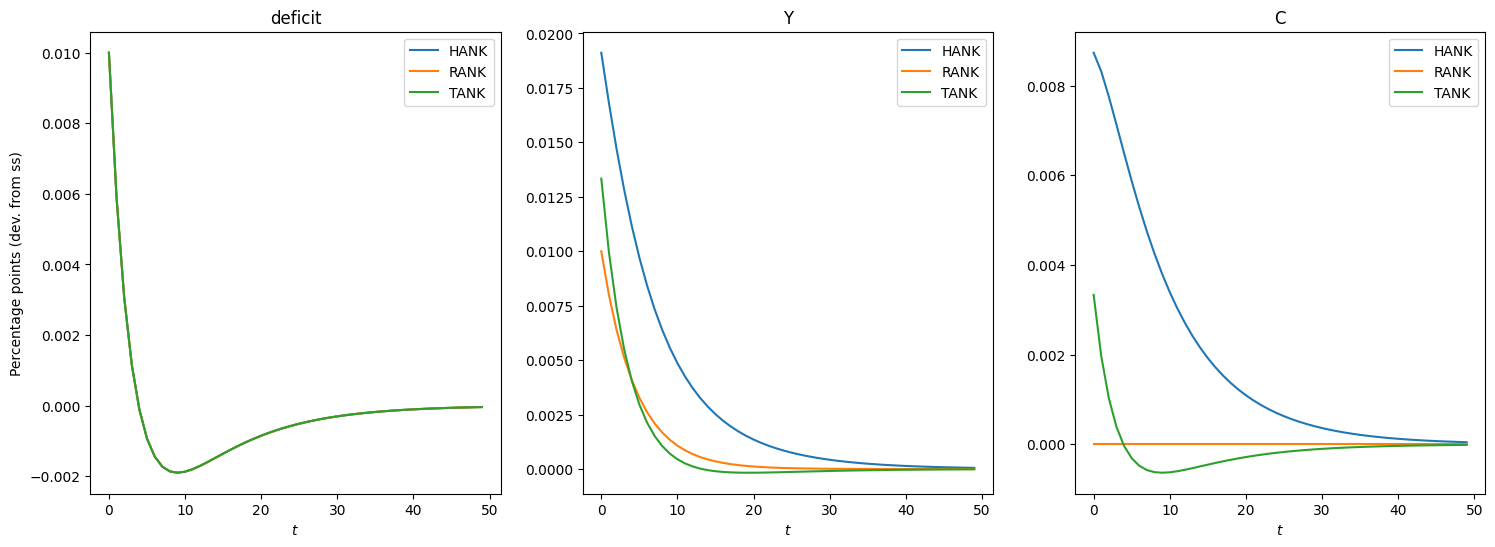

In [23]:
irfs_RANK = RANK.solve_impulse_linear(
    ss_RANK,
    unknowns_td,
    targets_td,
    shocks_B,
)  # solve for impulse responses in RANK model
irfs_TANK = TANK.solve_impulse_linear(
    ss_TANK,
    unknowns_td,
    targets_td,
    shocks_B,
)  # solve for impulse responses in TANK model

# Plot irfs of HANK, RANK, and TANK
show_irfs(
    [irfs_B_lin, irfs_RANK, irfs_TANK],
    variables=["deficit", "Y", "C"],
    labels=["HANK", "RANK", "TANK"],
)

# Simulating time series

## Simulate the economy subject to deficit financed government spending shocks.

In [24]:
from estimation.routines import simulate

outputs = ["Y", "C", "deficit", "G"]  # aggregate variables to be simulated

impulses_ha = {}
impulses_ra = {}
impulses_ta = {}

shk_std = 0.001  # standard deviation of shock
rho_G = 0.8  # persistence of G shock
rho_B = 0.9  # persistence of Deficit shock

dG = shk_std * 0.8 ** np.arange(T)  # G Shock series
dB = np.cumsum(dG) * rho_B ** np.arange(T)  # deficit shock series (fiscal rule)

# own_shock captures AR shock process to deficit financed G spending
own_shock = {"G": shk_std * rho_G ** np.arange(T), "B": dB}
impulses_ha["ha"] = HANK.solve_impulse_linear(
    SteadyState_dict,
    unknowns_td,
    targets_td,
    own_shock,
)  # solve impulse responses to HANK
impulses_ta["ta"] = TANK.solve_impulse_linear(
    ss_TANK,
    unknowns_td,
    targets_td,
    own_shock,
)  # solve impulse responses to TANK
impulses_ra["ra"] = RANK.solve_impulse_linear(
    ss_RANK,
    unknowns_td,
    targets_td,
    own_shock,
)  # solve impulse responses to RANK

T_sim = 80  # simulate for 80 quarters
data_simul_ha = simulate(
    list(impulses_ha.values()),
    outputs,
    T_sim,
)  # Simulate aggregate variables in 'outputs' in HANK
data_simul_ta = simulate(
    list(impulses_ta.values()),
    outputs,
    T_sim,
)  # Simulate aggregate variables in 'outputs' in TANK
data_simul_ra = simulate(
    list(impulses_ra.values()),
    outputs,
    T_sim,
)  # Simulate aggregate variables in 'outputs' in RANK

# Comparing time series of HANK, TANK, and RANK

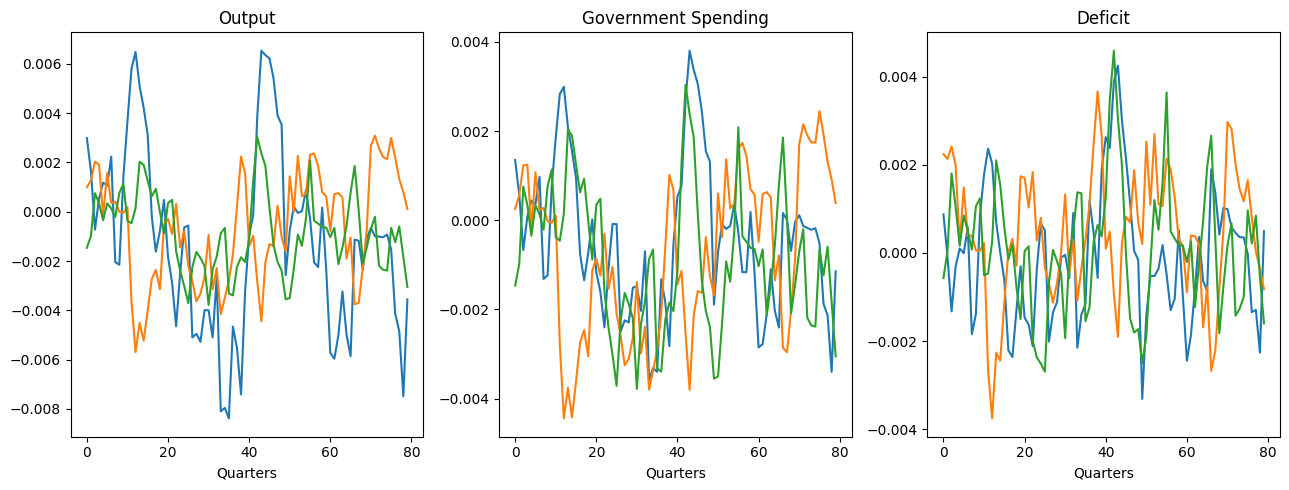

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))
axes[0].plot(data_simul_ha["Y"])
axes[0].plot(data_simul_ta["Y"])
axes[0].plot(data_simul_ra["Y"])
axes[0].set_title("Output")
axes[0].set_xlabel("Quarters")
axes[1].plot(data_simul_ha["G"])
axes[1].plot(data_simul_ta["G"])
axes[1].plot(data_simul_ra["G"])
axes[1].set_title("Government Spending")
axes[1].set_xlabel("Quarters")
axes[2].plot(data_simul_ha["deficit"])
axes[2].plot(data_simul_ta["deficit"])
axes[2].plot(data_simul_ra["deficit"])
axes[2].set_title("Deficit")
axes[2].set_xlabel("Quarters")
fig.tight_layout()